In [54]:
import re
import random
import pandas as pd
import hashlib

In [55]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [56]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
PEP 8,253.540392,8.742772,29
Taxes,345.558526,34.555853,10
WSL + Kali Linux,422.966303,12.440185,34
Finance Junk,519.043212,64.880402,8
Open Source/GitHub,529.974179,23.042356,23
PP365,850.478557,85.047856,10
sklearn,856.615251,122.373607,7
Powershell,961.384462,45.780212,21
Dataverse Plugins,963.052092,137.578870,7
AKS,1017.944058,127.243007,8


# Histogram

32065.84


<Axes: >

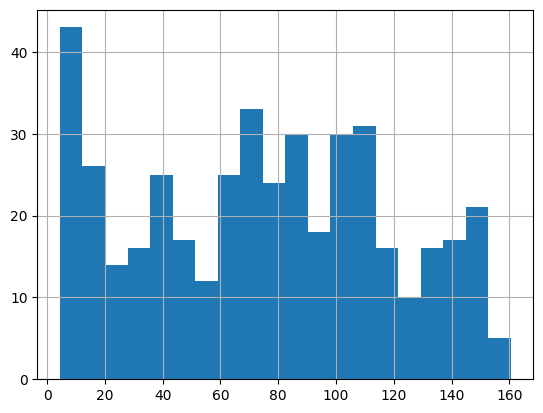

In [57]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [58]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [59]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [60]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [61]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [62]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [63]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [64]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [65]:
n = 8
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 429


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
190,Azure Functions,Just like the other triggers we've seen so far...,9f05ea1c19727cb36f9fc56e967f240c,-160.466257,95.784415,160.466257,2203.041536,0.059409,0,0
191,Azure Functions,"Three properties are required in all bindings,...",50635c412afa2fa925fd40f1f5609807,-148.901767,95.784415,160.466257,2203.041536,0.059409,1,0
192,Azure Functions,Every Azure Function must have exactly one tri...,d38d0a2b5b23859e6e661b151e31c454,-146.963592,95.784415,160.466257,2203.041536,0.059409,2,0
195,Azure Functions,"In an blob input binding definition:\n ""p...",d0c412d9f59e4ce78ab2ecc1dfc3bfbe,-146.032272,95.784415,160.466257,2203.041536,0.059409,3,0
193,Azure Functions,A binding expression is specialized text in fu...,c47f38f9a21e5d574f4667e9be063566,-145.023541,95.784415,160.466257,2203.041536,0.059409,4,0
194,Azure Functions,Trigger types and purpose:\nEvent Hub: Execute...,d8bafb4dfaa8edd97e63a3abf885a3b3,-143.993960,95.784415,160.466257,2203.041536,0.059409,5,0
197,Azure Functions,API Management\tAPIM provides security and rou...,a551c02d718c04c94e6b16fe94e0370d,-139.341004,95.784415,160.466257,2203.041536,0.059409,6,0
196,Azure Functions,Reasons to choose WebJobs over Azure Functions...,5dbe1e9c21756dabfafc61be2dab2409,-137.775737,95.784415,160.466257,2203.041536,0.059409,7,0
284,OData,Delta Queries allow clients to track changes (...,27d24f93b4b1b48bb6885dad01847dea,-123.338238,70.474329,123.338238,1832.332545,0.091205,0,0
285,OData,Navigation Links are URLs that provide access ...,d88e3655d1af4234a3783ebb3b89d503,-113.392161,70.474329,123.338238,1832.332545,0.091205,1,0


## Age Sum

In [66]:
# n=8
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [67]:
# n=6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Mean

In [68]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [69]:
existing_cards.head()

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
190,Azure Functions,Just like the other triggers we've seen so far...,9f05ea1c19727cb36f9fc56e967f240c,-160.466257,95.784415,160.466257,2203.041536,0.059409,0,0
191,Azure Functions,"Three properties are required in all bindings,...",50635c412afa2fa925fd40f1f5609807,-148.901767,95.784415,160.466257,2203.041536,0.059409,1,0
192,Azure Functions,Every Azure Function must have exactly one tri...,d38d0a2b5b23859e6e661b151e31c454,-146.963592,95.784415,160.466257,2203.041536,0.059409,2,0
195,Azure Functions,"In an blob input binding definition:\n ""p...",d0c412d9f59e4ce78ab2ecc1dfc3bfbe,-146.032272,95.784415,160.466257,2203.041536,0.059409,3,0
193,Azure Functions,A binding expression is specialized text in fu...,c47f38f9a21e5d574f4667e9be063566,-145.023541,95.784415,160.466257,2203.041536,0.059409,4,0


In [70]:
existing_cards.head(10)['age'].sum()

np.float64(-1405.2285295653032)